In [199]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.style as style

In [200]:
df_all = pd.read_csv("data_by_all_20230518.csv")
df_states = pd.read_csv("data_by_states_20230518.csv")

In [201]:
# ID를 기준으로 dataframe 머지.
df = pd.merge(df_states, df_all, on='ID')

In [202]:
# 작물이름에 따라 groupby
group_df = df.groupby('crop')

df_list = []  # 그룹을 저장할 딕셔너리

for group_id, df in group_df:
		if group_id != 'Wheat':
				# 아래 column들 삭제 및 column 명 변경
				df = df.drop(
						['productions_winter', 'harvested_winter', 'cultivated_winter'], axis=1)
				df = df.rename(
						columns={'productions_spring': 'productions', 'harvested_spring': 'harvested', 'cultivated_spring': 'cultivated'})
				
				# 결측치 있는 행 삭제
				df = df.dropna()
				df_list.append(df)
		else:
				# productions_spring 열과 productions_winter 열이 모두 빈 행 삭제
				df = df.dropna(
						subset=['productions_spring', 'productions_winter'], how='all')
				
				# 겨울철 밀 데이터
				winter = df.copy()
				winter = winter.drop(
						['productions_spring', 'harvested_spring', 'cultivated_spring'], axis=1)
				winter = winter.rename(
                                    columns={'productions_winter': 'productions', 'harvested_winter': 'harvested', 'cultivated_winter': 'cultivated'})
				
				# 봄철 밀 데이터
				spring = df.copy()
				spring = spring.drop(
						['productions_winter', 'harvested_winter', 'cultivated_winter'], axis=1)
				spring = spring.rename(
						columns={'productions_spring': 'productions', 'harvested_spring': 'harvested', 'cultivated_spring': 'cultivated'})
				
				winter.dropna()
				spring.dropna()
				df_list.append(spring)
				df_list.append(winter)

In [203]:
print(len(df_list[0]))
print(len(df_list[3]))


4428
4428


In [204]:
filtered_columns = ['ID', 'state', 'population_world', 'cpi_us', 'co2(ppm)',
                    'oil_price', 'sunlight_svm', 'food_consumption_us(kcal)', 'productions']

In [205]:
for idx, df in enumerate(df_list):
		new_df = df.filter(filtered_columns, axis=1)
		new_df['year-state'] = new_df['ID'].str[:4] + new_df['state']
		new_df.drop(['ID', 'state'], axis=1, inplace=True)
		df_list[idx] = new_df

In [206]:
train_df_list = []
test_df_list = []

for df in df_list:
		unique_values = df_list[0]['year-state'].unique()
		train_num = int(len(unique_values) / 10 * 9)
		random_values = random.sample(list(unique_values), train_num)

		df_train = df_list[0][df_list[0]['year-state'].isin(random_values)]
		df_test = df_list[0][~df_list[0]['year-state'].isin(random_values)]
		train_df_list.append(df_train)
		test_df_list.append(df_test)

In [207]:
print(len(train_df_list[0]))
print(len(test_df_list[0]))
print(len(df_list[0]))

3984
444
4428


In [208]:
scaler = MinMaxScaler(feature_range=(0.0001, 1.0))

def normalized(dataFrame, category):
    normalized_value = scaler.fit_transform(dataFrame[[category]])
    dataFrame[category] = normalized_value
    return dataFrame

In [209]:
normalized_columns = ['population_world', 'cpi_us', 'co2(ppm)',
                      'oil_price', 'sunlight_svm', 'food_consumption_us(kcal)', 'productions']

for idx, df in enumerate(train_df_list):
		new_df = df
		for column in normalized_columns:
				new_df = normalized(new_df, column)
		
		train_df_list[idx] = new_df

for idx, df in enumerate(test_df_list):
		new_df = df
		for column in normalized_columns:
				new_df = normalized(new_df, column)

		test_df_list[idx] = new_df

C:\Users\이성준\AppData\Local\Temp\ipykernel_8136\117708398.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame[category] = normalized_value
C:\Users\이성준\AppData\Local\Temp\ipykernel_8136\117708398.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame[category] = normalized_value
C:\Users\이성준\AppData\Local\Temp\ipykernel_8136\117708398.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [210]:
def make_data(df):
		# 각 'target' 값에 대응하는 'X' 값을 저장하기 위한 딕셔너리 생성
		X_dict = defaultdict(list)
		for _, row in df.iterrows():
				X = row.drop(['productions', 'year-state']).tolist()
				year_state = row['year-state']
				X_dict[year_state].append(X)

		# X와 y 분리
		X = [X_dict[year_state] for year_state in df['year-state']]
		y = df['productions'].values.tolist()

		return X, y

In [211]:
train_X_list = []
train_y_list = []

for train_df in train_df_list:
    X_train, y_train = make_data(train_df)
    train_X_list.append(X_train)
    train_y_list.append(y_train)

In [212]:
for X_set, target in zip(train_X_list[0], train_y_list[0]):
    print(f"y = {target}, X = {X_set}")

y = 0.04919638814015006, X = [[0.00010000000000000286, 9.99999999999994e-05, 9.999999999998899e-05, 0.00532189417043266, 0.235849469934696, 0.00010000000000021103], [0.0005691186124259368, 0.00012468359867563727, 0.0007424613941837688, 0.00532189417043266, 0.19203512000678483, 0.0006324598935361081], [0.0010382372248518429, 0.0001493671973512821, 0.0013849227883675486, 0.00532189417043266, 0.35457222457806803, 0.0011649197870724493], [0.0015073558372777698, 0.00017405079602692344, 0.0020273841825508843, 0.00532189417043266, 0.5326563565431262, 0.0016973796806083463], [0.00197647444970369, 0.00019873439470256826, 0.002669845576734664, 0.00532189417043266, 0.6188716902722416, 0.0022298395741442434], [0.00244559306212961, 0.00022341799337820614, 0.003312306970918222, 0.00532189417043266, 0.8223964125180223, 0.0027622994676801405], [0.00291471167455553, 0.00024810159205385096, 0.0039547683651017795, 0.00532189417043266, 0.7220474175218388, 0.0032947593612164816], [0.003383830286981457, 0.0

In [213]:
test_X_list = []
test_y_list = []

for test_df in test_df_list:
    X_test, y_test = make_data(test_df)
    test_X_list.append(X_test)
    test_y_list.append(y_test)

In [214]:
for X_set, target in zip(test_X_list[0], test_y_list[0]):
    print(f"y = {target}, X = {X_set}")


y = 0.05541336403096594, X = [[0.00010000000000000286, 0.00010000000000000286, 9.999999999998899e-05, 0.0049092475806441285, 0.26260075472814987, 0.00010000000000021103], [0.0005800643205810668, 0.00012837291182860033, 0.0007591211847088886, 0.0049092475806441285, 0.3513834226181668, 0.0006358842786058361], [0.0010601286411621377, 0.0001567458236571978, 0.001418242369417566, 0.0049092475806441285, 0.2877558439636547, 0.0011717685572119052], [0.0015401929617432086, 0.0001851187354858022, 0.0020773635541264657, 0.0049092475806441285, 0.5511444253707047, 0.0017076528358179743], [0.0020202572823242795, 0.00021349164731439968, 0.0027364847388353652, 0.0049092475806441285, 0.6443662266552225, 0.0022435371144235994], [0.0025003216029053435, 0.0002418645591430041, 0.0033956059235440428, 0.0049092475806441285, 0.7701416728327464, 0.0027794213930292244], [0.0029803859234864213, 0.00027023747097160156, 0.004054727108252942, 0.0049092475806441285, 0.9077548080622725, 0.0033153056716352935], [0.003

In [215]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y

In [216]:
# batch_size = 8
# train_dataset = CustomDataset(train_X_list[1], train_y_list[1])
# train_dataloader = DataLoader(
#     train_dataset, batch_size=batch_size, shuffle=True)

# filter_layers = nn.ModuleList()
# for i in range(6):
# 	filter_layer = nn.Linear(12, 5)
# 	nn.init.xavier_uniform_(filter_layer.weight)
# 	filter_layers.append(filter_layer)

# hidden_layers = nn.ModuleList()
# for i in range(2):
# 	hidden_layer = nn.Linear(
#             6 if i == 0 else 3, 3 if i != 1 else 1)
# 	nn.init.xavier_uniform_(hidden_layer.weight)
# 	hidden_layers.append(hidden_layer)

# output_layer = nn.Linear(5, 1)

# for X, y in train_dataloader:
# 		batch_size, sequence_length, feature_size = X.size()
# 		out = []
# 		sequence = X[0]
# 		outputs = []

# 		for i in range(6):
# 			feature = sequence[:, i]
# 			feature = feature.view(1, -1)
# 			# print(feature.shape)
# 			feature_o = filter_layers[i](feature)

# 			# print(feature_o.shape)
			
# 			outputs.append(feature_o)

# 		result = torch.cat(outputs, dim = 0)
# 		result = result.t()

# 		for layer in hidden_layers:
# 			result = layer(result)
		
# 		result = result.t()
# 		result = output_layer(result)
# 		result = torch.stack(result, dim=0)
# 		print(result.shape)
# 		break
			


In [217]:
class FieldCropsPredictionModel(nn.Module):
		def __init__(self, feature_num, filter_input_dim, filter_out_dim, hidden_dim, layer_num=2):
				super(FieldCropsPredictionModel, self).__init__()
				
				self.feature_num = feature_num

				self.filter_layers = nn.ModuleList()
				for i in range(feature_num):
					filter_layer = nn.Linear(filter_input_dim, filter_out_dim)
					nn.init.xavier_uniform_(filter_layer.weight)
					self.filter_layers.append(filter_layer)
				
				self.output_layer = nn.Linear(filter_out_dim, 1)
				
				nn.init.xavier_uniform_(self.output_layer.weight)
				
				self.hidden_layers = nn.ModuleList()
				for i in range(layer_num):
						hidden_layer = nn.Linear(
						    feature_num if i == 0 else hidden_dim, hidden_dim if i != layer_num-1 else 1)
						nn.init.xavier_uniform_(hidden_layer.weight)
						self.hidden_layers.append(hidden_layer)

				self.activation_function = nn.ELU()

		def forward(self, input):
				batch_size, sequence_length, feature_size = input.size()

				outputs = []
				for i in range(batch_size):
						sequence = input[i]
						filtered_outputs = []

						for j in range(self.feature_num):
							feature = sequence[:, j]
							feature = feature.view(1, -1)
							filtered_feature = self.filter_layers[j](feature)
							filtered_feature = self.activation_function(filtered_feature)
							filtered_outputs.append(filtered_feature)

						sequence_out = torch.cat(filtered_outputs, dim = 0)
						sequence_out = sequence_out.t()

						for layer in self.hidden_layers:
								sequence_out = layer(sequence_out)
								sequence_out = self.activation_function(sequence_out)

						sequence_out = sequence_out.t()
						sequence_out = self.output_layer(sequence_out)
						sequence_out = self.activation_function(sequence_out)
						
						outputs.append(sequence_out)

				result = torch.stack(outputs, dim=0)
				return result


In [218]:
def calculate_rmse(outputs, targets):
    mse = torch.mean((outputs - targets) ** 2)
    rmse = torch.sqrt(mse)
    return rmse

In [219]:
def train(model, dataloader, criterion, optim, scheduler, num_epochs):
		model.train()
		train_loss_list = []
		train_rmse_list = []

		for epoch in range(num_epochs):
				running_loss = 0.0
				running_rmse = 0.0
				
				for X, y in dataloader:
						outputs = model(X)
						loss = criterion(outputs, y)
						rmse = calculate_rmse(outputs, y)

						optim.zero_grad()
						loss.backward()
						optim.step()

						running_loss += loss.item()
						running_rmse += rmse.item()
						
				scheduler.step()

				epoch_loss = running_loss / len(dataloader.dataset)
				epoch_rmse = running_rmse / len(dataloader.dataset)

				print('Epoch [{}/{}], train_loss: {:.4f}, train_rmse: {:.4f}' .format(epoch +
				      1, num_epochs, epoch_loss, epoch_rmse))
				train_loss_list.append(torch.tensor(epoch_loss))
				train_rmse_list.append(torch.tensor(epoch_rmse))

		return model, train_loss_list, train_rmse_list


In [220]:
def test(model, dataloader, criterion, num_epochs):
		model.eval()
		test_loss_list = []
		test_rmse_list = []

		for epoch in range(num_epochs):
				running_loss = 0.0
				running_rmse = 0.0

				for X, y in dataloader:
						outputs = model(X)
						loss = criterion(outputs, y)
						rmse = calculate_rmse(outputs, y)

						running_loss += loss.item()
						running_rmse += rmse.item()

				epoch_loss = running_loss / len(dataloader.dataset)
				epoch_rmse = running_rmse / len(dataloader.dataset)

				test_loss_list.append(torch.tensor(epoch_loss))
				test_rmse_list.append(torch.tensor(epoch_rmse))
		
		return model, test_loss_list, test_rmse_list


In [221]:
# DataLoader로 데이터셋 생성
batch_size = 8

train_loss_list = []
train_rmse_list = []
test_loss_list = []
test_rmse_list = []

for i in range(4):
		model = FieldCropsPredictionModel(6, 12, 10, 8, 3)
		optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
		exp_lr_scheduler = optim.lr_scheduler.StepLR(
				optimizer_ft, step_size=7, gamma=0.1)
		criterion = nn.MSELoss()
		
		train_dataset = CustomDataset(train_X_list[i], train_y_list[i])
		train_dataloader = DataLoader(
					train_dataset, batch_size=batch_size, shuffle=True)

		test_dataset = CustomDataset(test_X_list[i], test_y_list[i])
		test_dataloader = DataLoader(
				test_dataset, batch_size=batch_size, shuffle=True)

		model_train, train_loss, train_rmse = train(
				model, train_dataloader, criterion, optimizer_ft, exp_lr_scheduler, 50)

		model_test, test_loss, test_rmse = test(
				model, test_dataloader, criterion, 50)
		
		train_loss_list.append(train_loss)
		train_rmse_list.append(train_rmse)
		test_loss_list.append(test_loss)
		test_rmse_list.append(test_rmse)


c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], train_loss: 0.0092, train_rmse: 0.0333
Epoch [2/50], train_loss: 0.0091, train_rmse: 0.0330
Epoch [3/50], train_loss: 0.0090, train_rmse: 0.0330
Epoch [4/50], train_loss: 0.0090, train_rmse: 0.0330
Epoch [5/50], train_loss: 0.0090, train_rmse: 0.0329
Epoch [6/50], train_loss: 0.0090, train_rmse: 0.0330
Epoch [7/50], train_loss: 0.0090, train_rmse: 0.0329
Epoch [8/50], train_loss: 0.0089, train_rmse: 0.0328
Epoch [9/50], train_loss: 0.0089, train_rmse: 0.0328
Epoch [10/50], train_loss: 0.0089, train_rmse: 0.0328
Epoch [11/50], train_loss: 0.0089, train_rmse: 0.0328
Epoch [12/50], train_loss: 0.0089, train_rmse: 0.0328
Epoch [13/50], train_loss: 0.0089, train_rmse: 0.0328
Epoch [14/50], train_loss: 0.0089, train_rmse: 0.0328
Epoch [15/50], train_loss: 0.0089, train_rmse: 0.0327
Epoch [16/50], train_loss: 0.0089, train_rmse: 0.0328
Epoch [17/50], train_loss: 0.0089, train_rmse: 0.0327
Epoch [18/50], train_loss: 0.0089, train_rmse: 0.0328
Epoch [19/50], train_loss: 0.0089, tr

c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], train_loss: 0.0095, train_rmse: 0.0339
Epoch [2/50], train_loss: 0.0092, train_rmse: 0.0335
Epoch [3/50], train_loss: 0.0092, train_rmse: 0.0334
Epoch [4/50], train_loss: 0.0092, train_rmse: 0.0334
Epoch [5/50], train_loss: 0.0092, train_rmse: 0.0334
Epoch [6/50], train_loss: 0.0092, train_rmse: 0.0334
Epoch [7/50], train_loss: 0.0092, train_rmse: 0.0334
Epoch [8/50], train_loss: 0.0091, train_rmse: 0.0332
Epoch [9/50], train_loss: 0.0091, train_rmse: 0.0332
Epoch [10/50], train_loss: 0.0091, train_rmse: 0.0333
Epoch [11/50], train_loss: 0.0091, train_rmse: 0.0332
Epoch [12/50], train_loss: 0.0091, train_rmse: 0.0332
Epoch [13/50], train_loss: 0.0091, train_rmse: 0.0333
Epoch [14/50], train_loss: 0.0091, train_rmse: 0.0332
Epoch [15/50], train_loss: 0.0091, train_rmse: 0.0332
Epoch [16/50], train_loss: 0.0091, train_rmse: 0.0332
Epoch [17/50], train_loss: 0.0091, train_rmse: 0.0332
Epoch [18/50], train_loss: 0.0091, train_rmse: 0.0332
Epoch [19/50], train_loss: 0.0091, tr

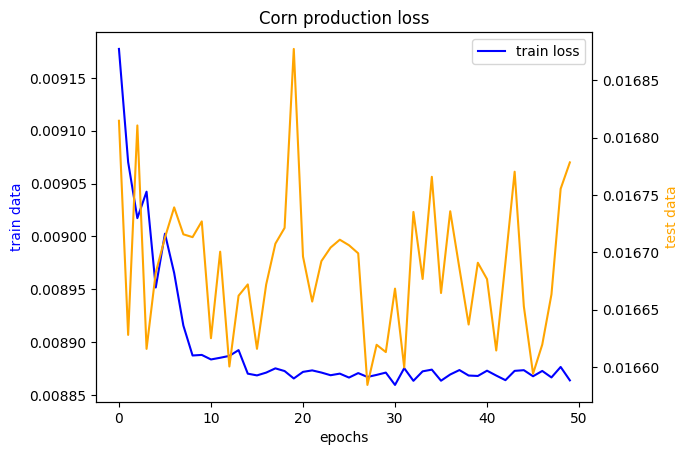

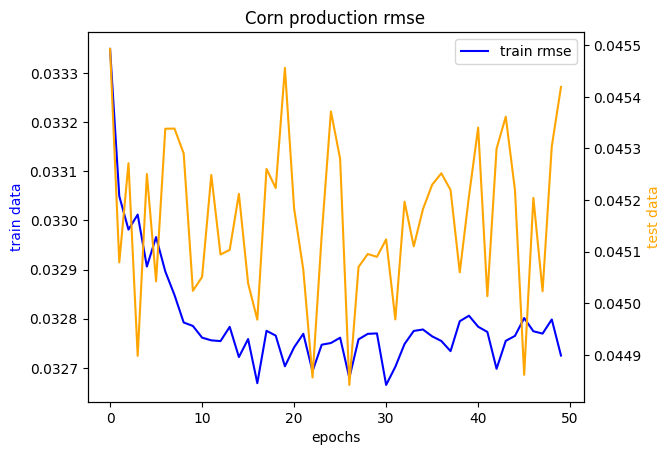

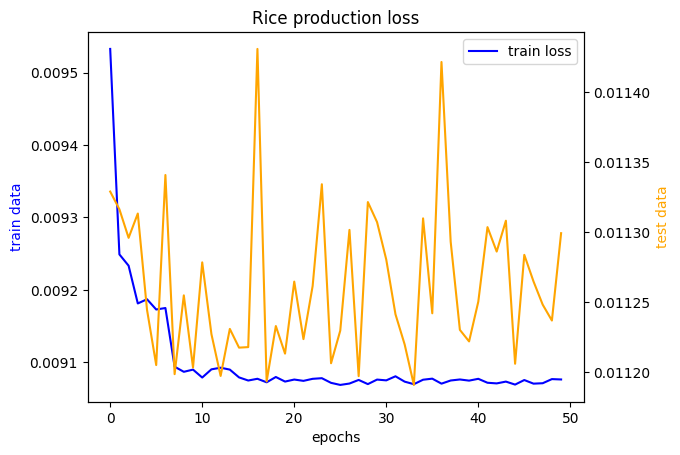

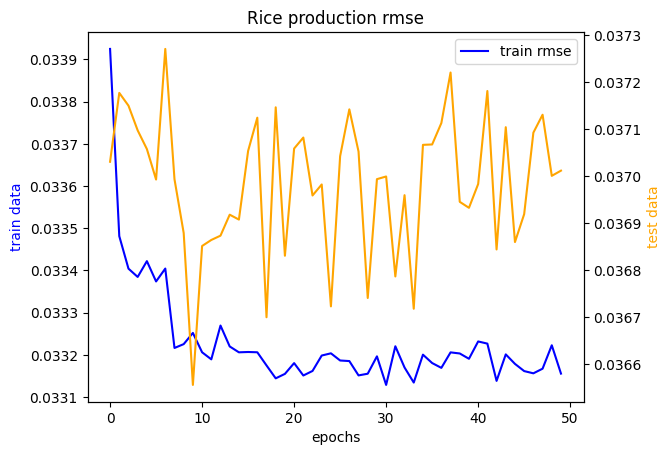

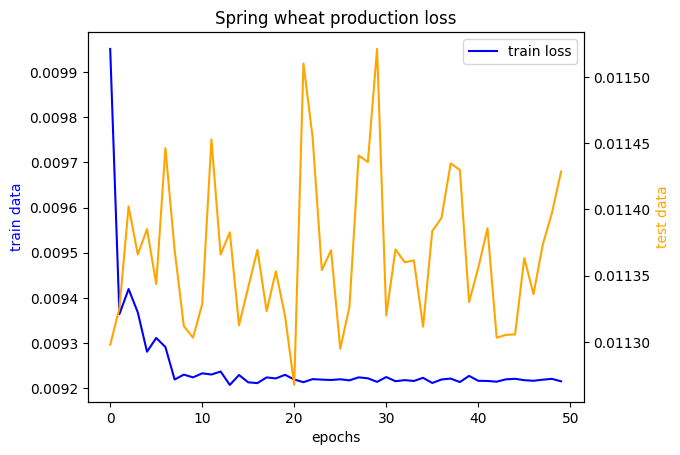

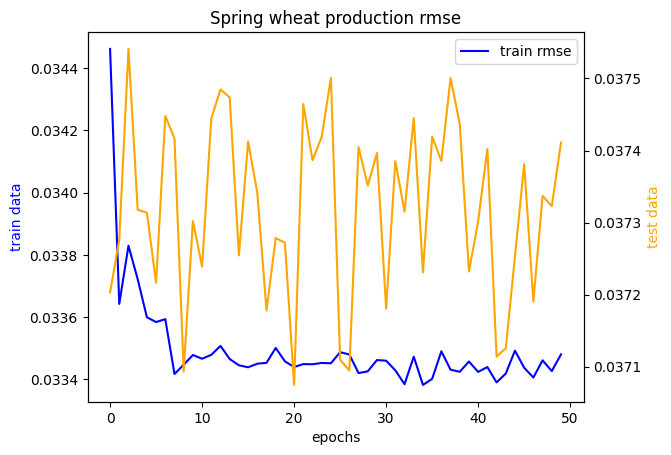

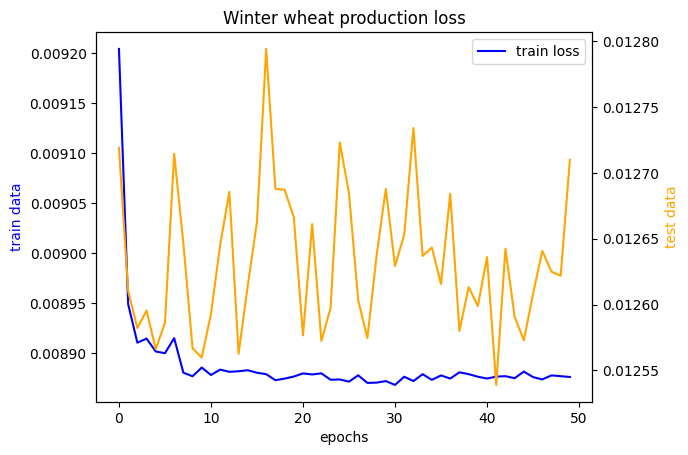

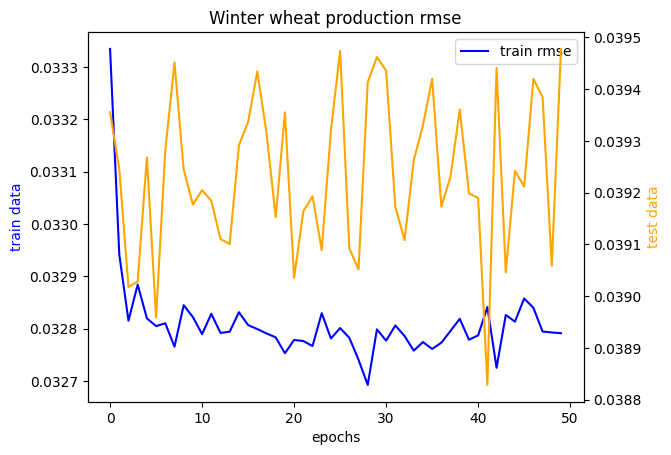

In [223]:
name = ['Corn', 'Rice', 'Spring wheat', 'Winter wheat']
for i in range(4):
	train_loss = train_loss_list[i]
	train_rmse = train_rmse_list[i]
	test_loss = test_loss_list[i]
	test_rmse = test_rmse_list[i]
	
	x = range(len(train_loss))
	y_train_loss = [loss.detach().numpy() for loss in train_loss]  # .detach().numpy() 사용
	y_test_loss = [loss.detach().numpy() for loss in test_loss]

	fig, ax1 = plt.subplots()
	ax1.plot(x, y_train_loss, 'b-', label='train loss')
	ax1.set_xlabel('epochs')
	ax1.set_ylabel('train data', color='b')
	ax1.legend(loc='best')

	ax2 = ax1.twinx()
	ax2.plot(x, y_test_loss, color='orange', label='test loss')
	ax2.set_ylabel('test data', color='orange')
	plt.title(name[i] + ' production loss')
	plt.show()

	x = range(len(train_rmse))
	y_train_rmse = [rmse.detach().numpy() for rmse in train_rmse]  # .detach().numpy() 사용
	y_test_rmse = [rmse.detach().numpy() for rmse in test_rmse]
        
	fig, ax1 = plt.subplots()
	ax1.plot(x, y_train_rmse, 'b-', label='train rmse')
	ax1.set_xlabel('epochs')
	ax1.set_ylabel('train data', color='b')
	ax1.legend(loc='best')

	ax2 = ax1.twinx()
	ax2.plot(x, y_test_rmse, color='orange', label='test lormsess')
	ax2.set_ylabel('test data', color='orange')
	plt.title(name[i] + ' production rmse')
	plt.show()


Fold 1


c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], train_loss: 0.0950, train_rmse: 0.1976
Epoch [2/50], train_loss: 0.0950, train_rmse: 0.1979
Epoch [3/50], train_loss: 0.0950, train_rmse: 0.1974
Epoch [4/50], train_loss: 0.0950, train_rmse: 0.1981
Epoch [5/50], train_loss: 0.0950, train_rmse: 0.1980
Epoch [6/50], train_loss: 0.0950, train_rmse: 0.1968
Epoch [7/50], train_loss: 0.0950, train_rmse: 0.1977
Epoch [8/50], train_loss: 0.0950, train_rmse: 0.1978
Epoch [9/50], train_loss: 0.0950, train_rmse: 0.1976
Epoch [10/50], train_loss: 0.0950, train_rmse: 0.1977
Epoch [11/50], train_loss: 0.0950, train_rmse: 0.1975
Epoch [12/50], train_loss: 0.0950, train_rmse: 0.1971
Epoch [13/50], train_loss: 0.0950, train_rmse: 0.1973
Epoch [14/50], train_loss: 0.0950, train_rmse: 0.1982
Epoch [15/50], train_loss: 0.0950, train_rmse: 0.1977
Epoch [16/50], train_loss: 0.0950, train_rmse: 0.1975
Epoch [17/50], train_loss: 0.0950, train_rmse: 0.1973
Epoch [18/50], train_loss: 0.0950, train_rmse: 0.1976
Epoch [19/50], train_loss: 0.0950, tr

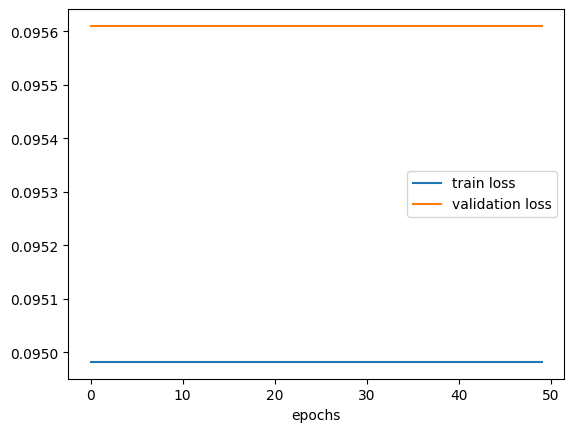

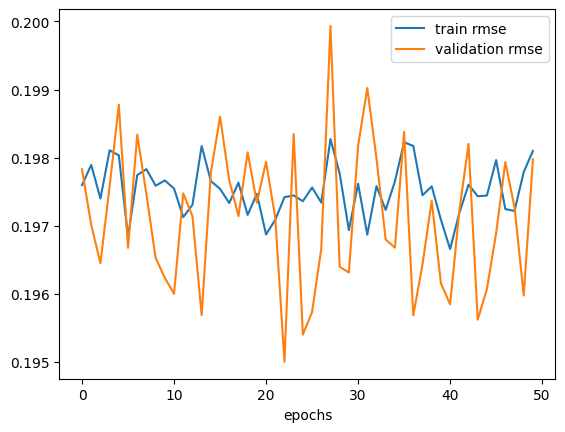

Fold 2


c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], train_loss: 0.0312, train_rmse: 0.1148
Epoch [2/50], train_loss: 0.0272, train_rmse: 0.1075
Epoch [3/50], train_loss: 0.0268, train_rmse: 0.1066
Epoch [4/50], train_loss: 0.0263, train_rmse: 0.1055
Epoch [5/50], train_loss: 0.0257, train_rmse: 0.1042
Epoch [6/50], train_loss: 0.0263, train_rmse: 0.1051
Epoch [7/50], train_loss: 0.0254, train_rmse: 0.1038
Epoch [8/50], train_loss: 0.0258, train_rmse: 0.1039
Epoch [9/50], train_loss: 0.0255, train_rmse: 0.1034
Epoch [10/50], train_loss: 0.0255, train_rmse: 0.1031
Epoch [11/50], train_loss: 0.0248, train_rmse: 0.1021
Epoch [12/50], train_loss: 0.0262, train_rmse: 0.1045
Epoch [13/50], train_loss: 0.0255, train_rmse: 0.1037
Epoch [14/50], train_loss: 0.0254, train_rmse: 0.1034
Epoch [15/50], train_loss: 0.0254, train_rmse: 0.1031
Epoch [16/50], train_loss: 0.0254, train_rmse: 0.1035
Epoch [17/50], train_loss: 0.0250, train_rmse: 0.1024
Epoch [18/50], train_loss: 0.0248, train_rmse: 0.1017
Epoch [19/50], train_loss: 0.0249, tr

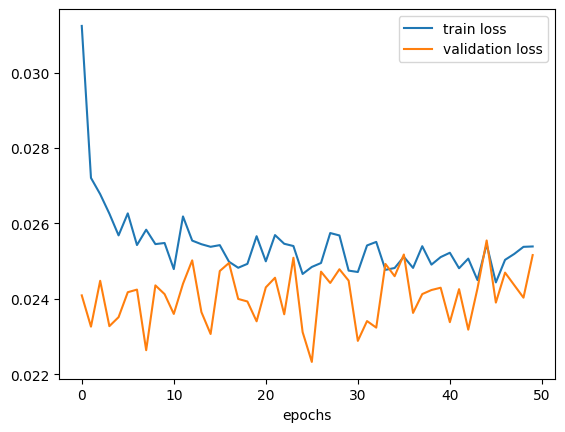

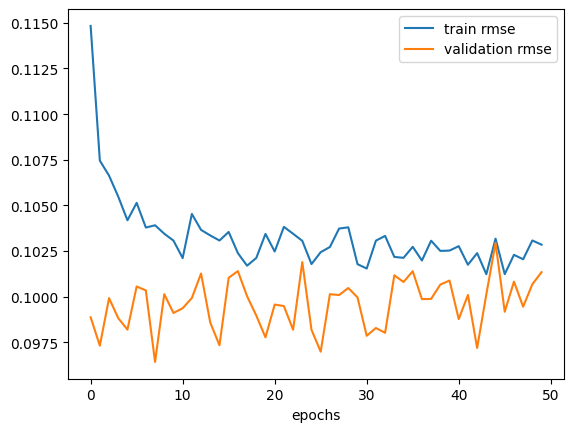

Fold 3
Epoch [1/50], train_loss: 0.0296, train_rmse: 0.1122
Epoch [2/50], train_loss: 0.0273, train_rmse: 0.1071
Epoch [3/50], train_loss: 0.0268, train_rmse: 0.1059
Epoch [4/50], train_loss: 0.0262, train_rmse: 0.1045
Epoch [5/50], train_loss: 0.0259, train_rmse: 0.1041
Epoch [6/50], train_loss: 0.0261, train_rmse: 0.1040
Epoch [7/50], train_loss: 0.0261, train_rmse: 0.1045
Epoch [8/50], train_loss: 0.0249, train_rmse: 0.1017
Epoch [9/50], train_loss: 0.0254, train_rmse: 0.1032
Epoch [10/50], train_loss: 0.0251, train_rmse: 0.1026
Epoch [11/50], train_loss: 0.0249, train_rmse: 0.1023
Epoch [12/50], train_loss: 0.0251, train_rmse: 0.1025
Epoch [13/50], train_loss: 0.0250, train_rmse: 0.1022
Epoch [14/50], train_loss: 0.0246, train_rmse: 0.1011
Epoch [15/50], train_loss: 0.0248, train_rmse: 0.1010
Epoch [16/50], train_loss: 0.0250, train_rmse: 0.1020
Epoch [17/50], train_loss: 0.0251, train_rmse: 0.1022
Epoch [18/50], train_loss: 0.0248, train_rmse: 0.1017
Epoch [19/50], train_loss: 0.0

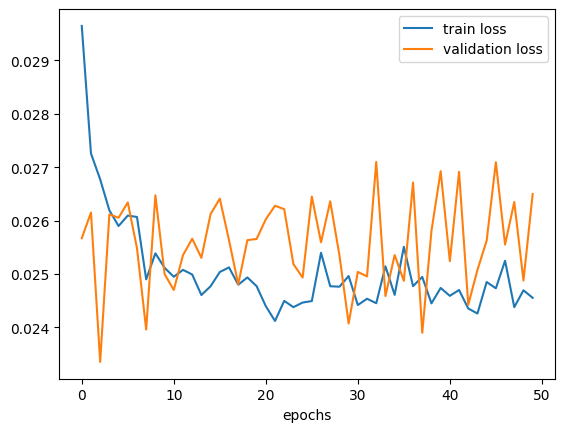

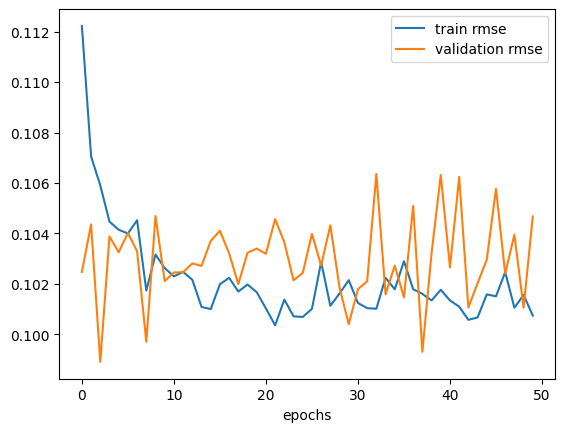

Fold 4
Epoch [1/50], train_loss: 0.0958, train_rmse: 0.1979
Epoch [2/50], train_loss: 0.0957, train_rmse: 0.1982
Epoch [3/50], train_loss: 0.0957, train_rmse: 0.1977
Epoch [4/50], train_loss: 0.0957, train_rmse: 0.1984
Epoch [5/50], train_loss: 0.0957, train_rmse: 0.1984
Epoch [6/50], train_loss: 0.0957, train_rmse: 0.1984
Epoch [7/50], train_loss: 0.0957, train_rmse: 0.1974
Epoch [8/50], train_loss: 0.0957, train_rmse: 0.1977
Epoch [9/50], train_loss: 0.0957, train_rmse: 0.1978
Epoch [10/50], train_loss: 0.0957, train_rmse: 0.1974
Epoch [11/50], train_loss: 0.0957, train_rmse: 0.1976
Epoch [12/50], train_loss: 0.0957, train_rmse: 0.1984
Epoch [13/50], train_loss: 0.0957, train_rmse: 0.1975
Epoch [14/50], train_loss: 0.0957, train_rmse: 0.1985
Epoch [15/50], train_loss: 0.0957, train_rmse: 0.1972
Epoch [16/50], train_loss: 0.0957, train_rmse: 0.1985
Epoch [17/50], train_loss: 0.0957, train_rmse: 0.1984
Epoch [18/50], train_loss: 0.0957, train_rmse: 0.1976
Epoch [19/50], train_loss: 0.0

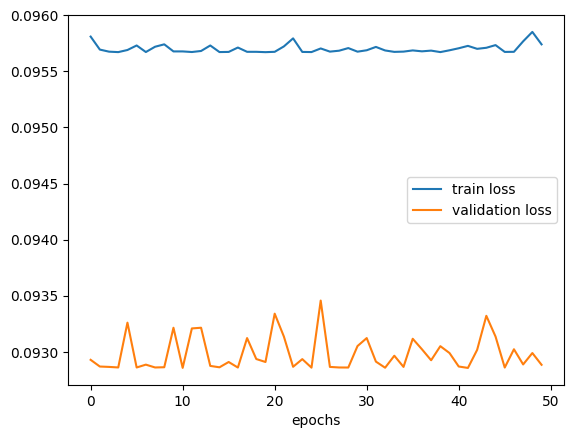

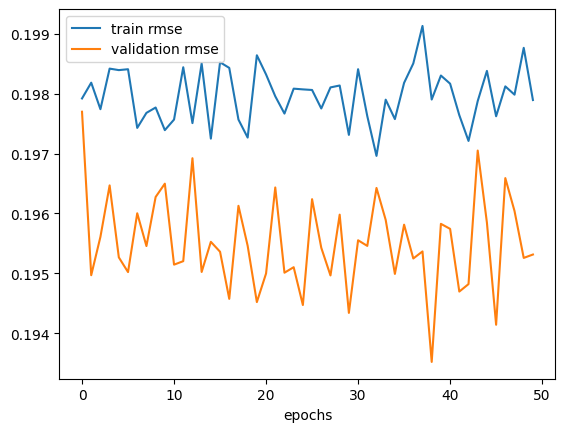

Fold 5
Epoch [1/50], train_loss: 0.0278, train_rmse: 0.1076
Epoch [2/50], train_loss: 0.0266, train_rmse: 0.1057
Epoch [3/50], train_loss: 0.0261, train_rmse: 0.1043
Epoch [4/50], train_loss: 0.0262, train_rmse: 0.1051
Epoch [5/50], train_loss: 0.0257, train_rmse: 0.1035
Epoch [6/50], train_loss: 0.0256, train_rmse: 0.1025
Epoch [7/50], train_loss: 0.0259, train_rmse: 0.1039
Epoch [8/50], train_loss: 0.0247, train_rmse: 0.1011
Epoch [9/50], train_loss: 0.0244, train_rmse: 0.1008
Epoch [10/50], train_loss: 0.0245, train_rmse: 0.1004
Epoch [11/50], train_loss: 0.0254, train_rmse: 0.1023
Epoch [12/50], train_loss: 0.0242, train_rmse: 0.1004
Epoch [13/50], train_loss: 0.0248, train_rmse: 0.1011
Epoch [14/50], train_loss: 0.0246, train_rmse: 0.1008
Epoch [15/50], train_loss: 0.0248, train_rmse: 0.1011
Epoch [16/50], train_loss: 0.0243, train_rmse: 0.1001
Epoch [17/50], train_loss: 0.0242, train_rmse: 0.1006
Epoch [18/50], train_loss: 0.0247, train_rmse: 0.1008
Epoch [19/50], train_loss: 0.0

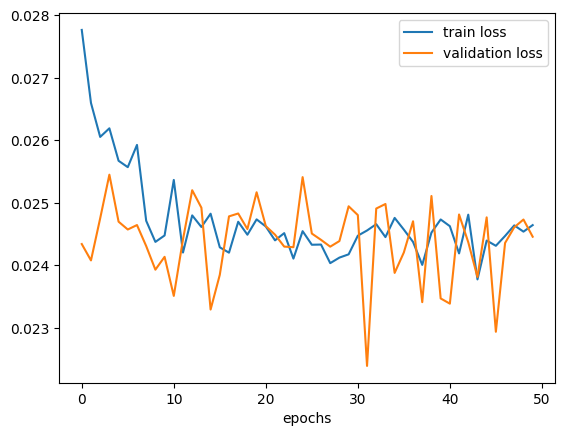

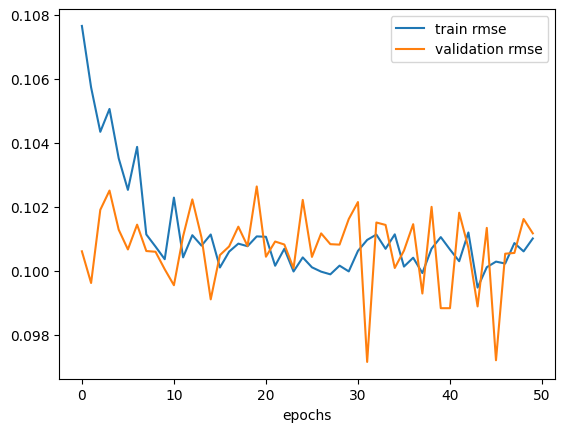

In [141]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_count = 1
for train_index, val_index in kf.split(X):
		X_train_fold = [X[i] for i in train_index]
		y_train_fold = [y[i] for i in train_index]
		X_val_fold = [X[i] for i in val_index]
		y_val_fold = [y[i] for i in val_index]

		train_dataset = CustomDataset(X_train_fold, y_train_fold)
		train_dataloader = DataLoader(
				train_dataset, batch_size=batch_size, shuffle=True)

		val_dataset = CustomDataset(X_val_fold, y_val_fold)
		val_dataloader = DataLoader(
				val_dataset, batch_size=batch_size, shuffle=True)

		model = FieldCropsPredictionModel(12, 24, 15, 2)
		optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
		exp_lr_scheduler = optim.lr_scheduler.StepLR(
				optimizer_ft, step_size=7, gamma=0.1)
		criterion = nn.MSELoss()

		print(f"Fold {fold_count}")
		fold_count += 1
		model_train, train_loss, train_rmse = train(
				model, train_dataloader, criterion, optimizer_ft, exp_lr_scheduler, 50)
		model_val, val_loss, val_rmse = validation(model, val_dataloader, criterion, 50)

		x = range(len(train_loss))
		y_train_loss = [loss.detach().numpy() for loss in train_loss]
		plt.plot(x, y_train_loss, label='train loss')

		y_val_loss = [loss.detach().numpy() for loss in val_loss]
		plt.plot(x, y_val_loss, label='validation loss')

		plt.legend(loc='best')
		plt.xlabel('epochs')
		plt.show()

		x = range(len(train_rmse))
		y_train_rmse = [rmse.detach().numpy() for rmse in train_rmse]
		plt.plot(x, y_train_rmse, label='train rmse')

		y_val_rmse = [rmse.detach().numpy() for rmse in val_rmse]
		plt.plot(x, y_val_rmse, label='validation rmse')

		plt.legend(loc='best')
		plt.xlabel('epochs')
		plt.show()
